In [1]:
from jaxpinns.base import PINN
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
from jax.config import config
from scipy.linalg import eigh
config.update("jax_enable_x64", True)
from scipy.optimize import minimize
from pyDOE import lhs
import matplotlib.pyplot as plt
from matplotlib import rc
from functools import partial
from jax import random, grad, jit, vmap, jvp
from jax.ops import segment_sum
from jax.scipy.optimize import minimize
import numpy as np
import igl
from jaxpinns.samplers import Sampler
from jax.example_libraries import optimizers
from jaxpinns.architectures import MLP
from jaxpinns.optimizers import adam, momentum
from jaxpinns.loggers import logger
from torch.utils import data
from scipy.sparse.linalg import spsolve
rng_key = random.PRNGKey(0)
import time
import meshio
import pyvista as pv #requires python environment 3.7+
import tetgen
import sys
sys.path.append("utils")
from Mesh_tetra import Mesh
import os
from timeit import default_timer as timer

# To make graphs look better
import seaborn as sns
sns.set_theme()
import pandas as pd
from matplotlib.ticker import MultipleLocator
import csv

c:\Users\Rodrigo\anaconda3\envs\jaxgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#S1
S1_50, S1_50_25, S1_50_75 = jnp.median(jnp.array(np.genfromtxt('S1_data/S1_50/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S1_data/S1_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S1_data/S1_50/Eff.csv')), 75, axis = 1)
S1_80, S1_80_25, S1_80_75 = jnp.median(jnp.array(np.genfromtxt('S1_data/S1_80/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S1_data/S1_80/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S1_data/S1_80/Eff.csv')), 75, axis = 1)
S1_no_mid, S1_no_mid_25, S1_no_mid_75  = jnp.median(jnp.array(np.genfromtxt('S1_data/S1_no_mid/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S1_data/S1_no_mid/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S1_data/S1_no_mid/Eff.csv')), 75, axis = 1)
time_S1 = np.arange(0, S1_50.shape[0], 1)

#S2
S2_50, S2_50_25, S2_50_75 = jnp.median(jnp.array(np.genfromtxt('S2_data/S2_50/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S2_data/S2_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S2_data/S2_50/Eff.csv')), 75, axis = 1)
S2_80, S2_80_25, S2_80_75 = jnp.median(jnp.array(np.genfromtxt('S2_data/S2_80/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S2_data/S2_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S2_data/S2_50/Eff.csv')), 75, axis = 1)
S2_no_mid, S2_no_mid_25, S2_no_mid_75 = jnp.median(jnp.array(np.genfromtxt('S2_data/S2_no_mid/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S2_data/S2_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S2_data/S2_50/Eff.csv')), 75, axis = 1)
time_S2 = np.arange(0, S2_50.shape[0], 1)

#S3
S3_50, S3_50_25, S3_50_75 = jnp.median(jnp.array(np.genfromtxt('S3_data/S3_50/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S3_data/S3_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S3_data/S3_50/Eff.csv')), 75, axis = 1)
S3_80, S3_80_25, S3_80_75 = jnp.median(jnp.array(np.genfromtxt('S3_data/S3_80/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S3_data/S3_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S3_data/S3_50/Eff.csv')), 75, axis = 1)
S3_no_mid, S3_no_mid_25, S3_no_mid_75 = jnp.median(jnp.array(np.genfromtxt('S3_data/S3_no_mid/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S3_data/S3_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S3_data/S3_50/Eff.csv')), 75, axis = 1)
time_S3 = np.arange(0, S3_50.shape[0], 1)

#S4
S4_50, S4_50_25, S4_50_75 = jnp.median(jnp.array(np.genfromtxt('S4_data/S4_50/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S4_data/S4_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S4_data/S4_50/Eff.csv')), 75, axis = 1)
S4_80, S4_80_25, S4_80_75 = jnp.median(jnp.array(np.genfromtxt('S4_data/S4_80/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S4_data/S4_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S4_data/S4_50/Eff.csv')), 75, axis = 1)
S4_no_mid, S4_no_mid_25, S4_no_mid_75 = jnp.median(jnp.array(np.genfromtxt('S4_data/S4_no_mid/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S4_data/S4_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S4_data/S4_50/Eff.csv')), 75, axis = 1)
time_S4 = np.arange(0, S4_50.shape[0], 1)

#S5
S5_50, S5_50_25, S5_50_75 = jnp.median(jnp.array(np.genfromtxt('S5_data/S5_50/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S5_data/S5_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S5_data/S5_50/Eff.csv')), 75, axis = 1)
S5_80, S5_80_25, S5_80_75 = jnp.median(jnp.array(np.genfromtxt('S5_data/S5_80/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S5_data/S5_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S5_data/S5_50/Eff.csv')), 75, axis = 1)
S5_no_mid, S5_no_mid_25, S5_no_mid_75 = jnp.median(jnp.array(np.genfromtxt('S5_data/S5_no_mid/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S5_data/S5_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S5_data/S5_50/Eff.csv')), 75, axis = 1)
time_S5 = np.arange(0, S5_50.shape[0], 1)

#S6
S6_50, S6_50_25, S6_50_75 = jnp.median(jnp.array(np.genfromtxt('S6_data/S6_50/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S6_data/S6_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S6_data/S6_50/Eff.csv')), 75, axis = 1)
S6_80, S6_80_25, S6_80_75 = jnp.median(jnp.array(np.genfromtxt('S6_data/S6_80/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S6_data/S6_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S6_data/S6_50/Eff.csv')), 75, axis = 1)
S6_no_mid, S6_no_mid_25, S6_no_mid_75 = jnp.median(jnp.array(np.genfromtxt('S6_data/S6_no_mid/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S6_data/S6_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S6_data/S6_50/Eff.csv')), 75, axis = 1)
time_S6 = np.arange(0, S6_50.shape[0], 1)

#S7
S7_50, S7_50_25, S7_50_75 = jnp.median(jnp.array(np.genfromtxt('S7_data/S7_50/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S7_data/S7_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S7_data/S7_50/Eff.csv')), 75, axis = 1)
S7_80, S7_80_25, S7_80_75 = jnp.median(jnp.array(np.genfromtxt('S7_data/S7_80/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S7_data/S7_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S7_data/S7_50/Eff.csv')), 75, axis = 1)
S7_no_mid, S7_no_mid_25, S7_no_mid_75 = jnp.median(jnp.array(np.genfromtxt('S7_data/S7_no_mid/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S7_data/S7_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S7_data/S7_50/Eff.csv')), 75, axis = 1)
time_S7 = np.arange(0, S7_50.shape[0], 1)

#S8
S8_50, S8_50_25, S8_50_75 = jnp.median(jnp.array(np.genfromtxt('S8_data/S8_50/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S8_data/S8_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S8_data/S8_50/Eff.csv')), 75, axis = 1)
S8_80, S8_80_25, S8_80_75 = jnp.median(jnp.array(np.genfromtxt('S8_data/S8_80/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S8_data/S8_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S8_data/S8_50/Eff.csv')), 75, axis = 1)
S8_no_mid, S8_no_mid_25, S8_no_mid_75 = jnp.median(jnp.array(np.genfromtxt('S8_data/S8_no_mid/Eff.csv')), axis = 1), np.percentile(jnp.array(np.genfromtxt('S8_data/S8_50/Eff.csv')), 25, axis = 1), np.percentile(jnp.array(np.genfromtxt('S8_data/S8_50/Eff.csv')), 75, axis = 1)
time_S8 = np.arange(0, S8_50.shape[0], 1)

In [15]:
#S1
S1_50_mean, S1_50_std = jnp.mean(jnp.array(np.genfromtxt('S1_data/S1_50/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S1_data/S1_50/Eff.csv')), axis = 1)
S1_80_mean, S1_80_std = jnp.mean(jnp.array(np.genfromtxt('S1_data/S1_80/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S1_data/S1_80/Eff.csv')), axis = 1)
S1_no_mid_mean, S1_no_mid_std = jnp.mean(jnp.array(np.genfromtxt('S1_data/S1_no_mid/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S1_data/S1_no_mid/Eff.csv')), axis = 1)
time_S1 = np.arange(0, S1_50_mean.shape[0], 1)

#S2
S2_50_mean, S2_50_std = jnp.mean(jnp.array(np.genfromtxt('S2_data/S2_50/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S2_data/S2_50/Eff.csv')), axis = 1)
S2_80_mean, S2_80_std = jnp.mean(jnp.array(np.genfromtxt('S2_data/S2_80/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S2_data/S2_80/Eff.csv')), axis = 1)
S2_no_mid_mean, S2_no_mid_std = jnp.mean(jnp.array(np.genfromtxt('S2_data/S2_no_mid/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S2_data/S2_no_mid/Eff.csv')), axis = 1)
time_S2 = np.arange(0, S2_50_mean.shape[0], 1)

#S3
S3_50_mean, S3_50_std = jnp.mean(jnp.array(np.genfromtxt('S3_data/S3_50/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S3_data/S3_50/Eff.csv')), axis = 1)
S3_80_mean, S3_80_std = jnp.mean(jnp.array(np.genfromtxt('S3_data/S3_80/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S3_data/S3_80/Eff.csv')), axis = 1)
S3_no_mid_mean, S3_no_mid_std = jnp.mean(jnp.array(np.genfromtxt('S3_data/S3_no_mid/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S3_data/S3_no_mid/Eff.csv')), axis = 1)
time_S3 = np.arange(0, S3_50_mean.shape[0], 1)

#S4
S4_50_mean, S4_50_std = jnp.mean(jnp.array(np.genfromtxt('S4_data/S4_50/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S4_data/S4_50/Eff.csv')), axis = 1)
S4_80_mean, S4_80_std = jnp.mean(jnp.array(np.genfromtxt('S4_data/S4_80/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S4_data/S4_80/Eff.csv')), axis = 1)
S4_no_mid_mean, S4_no_mid_std = jnp.mean(jnp.array(np.genfromtxt('S4_data/S4_no_mid/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S4_data/S4_no_mid/Eff.csv')), axis = 1)
time_S4 = np.arange(0, S4_50_mean.shape[0], 1)

#S5
S5_50_mean, S5_50_std = jnp.mean(jnp.array(np.genfromtxt('S5_data/S5_50/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S5_data/S5_50/Eff.csv')), axis = 1)
S5_80_mean, S5_80_std = jnp.mean(jnp.array(np.genfromtxt('S5_data/S5_80/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S5_data/S5_80/Eff.csv')), axis = 1)
S5_no_mid_mean, S5_no_mid_std = jnp.mean(jnp.array(np.genfromtxt('S5_data/S5_no_mid/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S5_data/S5_no_mid/Eff.csv')), axis = 1)
time_S5 = np.arange(0, S5_50_mean.shape[0], 1)

#S6
S6_50_mean, S6_50_std = jnp.mean(jnp.array(np.genfromtxt('S6_data/S6_50/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S6_data/S6_50/Eff.csv')), axis = 1)
S6_80_mean, S6_80_std = jnp.mean(jnp.array(np.genfromtxt('S6_data/S6_80/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S6_data/S6_80/Eff.csv')), axis = 1)
S6_no_mid_mean, S6_no_mid_std = jnp.mean(jnp.array(np.genfromtxt('S6_data/S6_no_mid/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S6_data/S6_no_mid/Eff.csv')), axis = 1)
time_S6 = np.arange(0, S6_50_mean.shape[0], 1)

#S7
S7_50_mean, S7_50_std = jnp.mean(jnp.array(np.genfromtxt('S7_data/S7_50/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S7_data/S7_50/Eff.csv')), axis = 1)
S7_80_mean, S7_80_std = jnp.mean(jnp.array(np.genfromtxt('S7_data/S7_80/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S7_data/S7_80/Eff.csv')), axis = 1)
S7_no_mid_mean, S7_no_mid_std = jnp.mean(jnp.array(np.genfromtxt('S7_data/S7_no_mid/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S7_data/S7_no_mid/Eff.csv')), axis = 1)
time_S7 = np.arange(0, S7_50_mean.shape[0], 1)

#S8
S8_50_mean, S8_50_std = jnp.mean(jnp.array(np.genfromtxt('S8_data/S8_50/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S8_data/S8_50/Eff.csv')), axis = 1)
S8_80_mean, S8_80_std = jnp.mean(jnp.array(np.genfromtxt('S8_data/S8_80/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S8_data/S8_80/Eff.csv')), axis = 1)
S8_no_mid_mean, S8_no_mid_std = jnp.mean(jnp.array(np.genfromtxt('S8_data/S8_no_mid/Eff.csv')), axis = 1), np.std(jnp.array(np.genfromtxt('S8_data/S8_no_mid/Eff.csv')), axis = 1)
time_S8 = np.arange(0, S8_50_mean.shape[0], 1)

In [3]:
E_ff_median_50 = []
E_ff_median_80 = []
E_ff_median_nomid = []
E_ff_25_50 = []
E_ff_75_50 = []
E_ff_25_80 = []
E_ff_75_80 = []
E_ff_25_nomid = []
E_ff_75_nomid = []

for x in range(8):
    E_ff_median_50.append(S1_50.min())
    E_ff_median_50.append(S2_50.min())
    E_ff_median_50.append(S3_50.min())
    E_ff_median_50.append(S4_50.min())
    E_ff_median_50.append(S5_50.min())
    E_ff_median_50.append(S6_50.min())
    E_ff_median_50.append(S7_50.min())
    E_ff_median_50.append(S8_50.min())

    E_ff_median_80.append(S1_80.min())
    E_ff_median_80.append(S2_80.min())
    E_ff_median_80.append(S3_80.min())
    E_ff_median_80.append(S4_80.min())
    E_ff_median_80.append(S5_80.min())
    E_ff_median_80.append(S6_80.min())
    E_ff_median_80.append(S7_80.min())
    E_ff_median_80.append(S8_80.min())

    E_ff_median_nomid.append(S1_no_mid.min())
    E_ff_median_nomid.append(S2_no_mid.min())
    E_ff_median_nomid.append(S3_no_mid.min())
    E_ff_median_nomid.append(S4_no_mid.min())
    E_ff_median_nomid.append(S5_no_mid.min())
    E_ff_median_nomid.append(S6_no_mid.min())
    E_ff_median_nomid.append(S7_no_mid.min())
    E_ff_median_nomid.append(S8_no_mid.min())

E_ff_median_50 = jnp.array(E_ff_median_50)
E_ff_median_80 = jnp.array(E_ff_median_80)
E_ff_median_nomid = jnp.array(E_ff_median_nomid)

for x in range(8):
    E_ff_25_50.append(S1_50_25.min())
    E_ff_25_50.append(S2_50_25.min())
    E_ff_25_50.append(S3_50_25.min())
    E_ff_25_50.append(S4_50_25.min())
    E_ff_25_50.append(S5_50_25.min())
    E_ff_25_50.append(S6_50_25.min())
    E_ff_25_50.append(S7_50_25.min())
    E_ff_25_50.append(S8_50_25.min())

    E_ff_25_80.append(S1_80_25.min())
    E_ff_25_80.append(S2_80_25.min())
    E_ff_25_80.append(S3_80_25.min())
    E_ff_25_80.append(S4_80_25.min())
    E_ff_25_80.append(S5_80_25.min())
    E_ff_25_80.append(S6_80_25.min())
    E_ff_25_80.append(S7_80_25.min())
    E_ff_25_80.append(S8_80_25.min())

    E_ff_25_nomid.append(S1_no_mid_25.min())
    E_ff_25_nomid.append(S2_no_mid_25.min())
    E_ff_25_nomid.append(S3_no_mid_25.min())
    E_ff_25_nomid.append(S4_no_mid_25.min())
    E_ff_25_nomid.append(S5_no_mid_25.min())
    E_ff_25_nomid.append(S6_no_mid_25.min())
    E_ff_25_nomid.append(S7_no_mid_25.min())
    E_ff_25_nomid.append(S8_no_mid_25.min())

E_ff_25_50 = jnp.array(E_ff_25_50)
E_ff_25_80 = jnp.array(E_ff_25_80)
E_ff_25_nomid = jnp.array(E_ff_25_nomid)


for x in range(8):
    E_ff_75_50.append(S1_50_75.min())
    E_ff_75_50.append(S2_50_75.min())
    E_ff_75_50.append(S3_50_75.min())
    E_ff_75_50.append(S4_50_75.min())
    E_ff_75_50.append(S5_50_75.min())
    E_ff_75_50.append(S6_50_75.min())
    E_ff_75_50.append(S7_50_75.min())
    E_ff_75_50.append(S8_50_75.min())

    E_ff_75_80.append(S1_80_75.min())
    E_ff_75_80.append(S2_80_75.min())
    E_ff_75_80.append(S3_80_75.min())
    E_ff_75_80.append(S4_80_75.min())
    E_ff_75_80.append(S5_80_75.min())
    E_ff_75_80.append(S6_80_75.min())
    E_ff_75_80.append(S7_80_75.min())
    E_ff_75_80.append(S8_80_75.min())

    E_ff_75_nomid.append(S1_no_mid_75.min())
    E_ff_75_nomid.append(S2_no_mid_75.min())
    E_ff_75_nomid.append(S3_no_mid_75.min())
    E_ff_75_nomid.append(S4_no_mid_75.min())
    E_ff_75_nomid.append(S5_no_mid_75.min())
    E_ff_75_nomid.append(S6_no_mid_75.min())
    E_ff_75_nomid.append(S7_no_mid_75.min())
    E_ff_75_nomid.append(S8_no_mid_75.min())

E_ff_75_50 = jnp.array(E_ff_75_50)
E_ff_75_80 = jnp.array(E_ff_75_80)
E_ff_75_nomid = jnp.array(E_ff_75_nomid)




print("Median across al subjects for 50 percent data is", E_ff_median_50.mean())
print("First quartile across al subjects for 50 percent data is", E_ff_25_50.mean())
print("Third quartile across al subjects for 50 percent data is", E_ff_75_50.mean(), "\n")


print("Median across al subjects for 80 percent data is", E_ff_median_80.mean())
print("First quartile across al subjects for 80 percent data is", E_ff_25_80.mean())
print("Third quartile across al subjects for 80 percent data is", E_ff_75_80.mean(), "\n")

print("Median across al subjects for nomid percent data is", E_ff_median_nomid.mean())
print("First quartile across al subjects for nomid percent data is", E_ff_25_nomid.mean())
print("Third quartile across al subjects for nomid percent data is", E_ff_75_nomid.mean())


Median across al subjects for 50 percent data is -0.13405659569295164
First quartile across al subjects for 50 percent data is -0.1533628461262363
Third quartile across al subjects for 50 percent data is -0.11298815881709555 

Median across al subjects for 80 percent data is -0.1354150625932382
First quartile across al subjects for 80 percent data is -0.15287638515721752
Third quartile across al subjects for 80 percent data is -0.11261787548064682 

Median across al subjects for nomid percent data is -0.12982607466760288
First quartile across al subjects for nomid percent data is -0.15246746859371596
Third quartile across al subjects for nomid percent data is -0.11209829238195972


In [16]:
E_ff_mean_50 = []
E_ff_mean_80 = []
E_ff_mean_nomid = []
E_ff_std_50 = []
E_ff_std_80 = []
E_ff_std_nomid = []

for x in range(8):
    E_ff_mean_50.append(S1_50_mean.min())
    E_ff_mean_50.append(S2_50_mean.min())
    E_ff_mean_50.append(S3_50_mean.min())
    E_ff_mean_50.append(S4_50_mean.min())
    E_ff_mean_50.append(S5_50_mean.min())
    E_ff_mean_50.append(S6_50_mean.min())
    E_ff_mean_50.append(S7_50_mean.min())
    E_ff_mean_50.append(S8_50_mean.min())

    E_ff_mean_80.append(S1_80_mean.min())
    E_ff_mean_80.append(S2_80_mean.min())
    E_ff_mean_80.append(S3_80_mean.min())
    E_ff_mean_80.append(S4_80_mean.min())
    E_ff_mean_80.append(S5_80_mean.min())
    E_ff_mean_80.append(S6_80_mean.min())
    E_ff_mean_80.append(S7_80_mean.min())
    E_ff_mean_80.append(S8_80_mean.min())

    E_ff_mean_nomid.append(S1_no_mid_mean.min())
    E_ff_mean_nomid.append(S2_no_mid_mean.min())
    E_ff_mean_nomid.append(S3_no_mid_mean.min())
    E_ff_mean_nomid.append(S4_no_mid_mean.min())
    E_ff_mean_nomid.append(S5_no_mid_mean.min())
    E_ff_mean_nomid.append(S6_no_mid_mean.min())
    E_ff_mean_nomid.append(S7_no_mid_mean.min())
    E_ff_mean_nomid.append(S8_no_mid_mean.min())

E_ff_mean_50 = jnp.array(E_ff_mean_50)
E_ff_mean_80 = jnp.array(E_ff_mean_80)
E_ff_mean_nomid = jnp.array(E_ff_mean_nomid)

for x in range(8):
    E_ff_std_50.append(S1_50_std.min())
    E_ff_std_50.append(S2_50_std.min())
    E_ff_std_50.append(S3_50_std.min())
    E_ff_std_50.append(S4_50_std.min())
    E_ff_std_50.append(S5_50_std.min())
    E_ff_std_50.append(S6_50_std.min())
    E_ff_std_50.append(S7_50_std.min())
    E_ff_std_50.append(S8_50_std.min())

    E_ff_std_80.append(S1_80_std.min())
    E_ff_std_80.append(S2_80_std.min())
    E_ff_std_80.append(S3_80_std.min())
    E_ff_std_80.append(S4_80_std.min())
    E_ff_std_80.append(S5_80_std.min())
    E_ff_std_80.append(S6_80_std.min())
    E_ff_std_80.append(S7_80_std.min())
    E_ff_std_80.append(S8_80_std.min())

    E_ff_std_nomid.append(S1_no_mid_std.min())
    E_ff_std_nomid.append(S2_no_mid_std.min())
    E_ff_std_nomid.append(S3_no_mid_std.min())
    E_ff_std_nomid.append(S4_no_mid_std.min())
    E_ff_std_nomid.append(S5_no_mid_std.min())
    E_ff_std_nomid.append(S6_no_mid_std.min())
    E_ff_std_nomid.append(S7_no_mid_std.min())
    E_ff_std_nomid.append(S8_no_mid_std.min())

E_ff_std_50 = jnp.array(E_ff_std_50)
E_ff_std_80 = jnp.array(E_ff_std_80)
E_ff_std_nomid = jnp.array(E_ff_std_nomid)


print("Mean across al subjects for 50 percent data is", E_ff_mean_50.mean())
print("Std across al subjects for 50 percent data is", E_ff_std_50.mean(), "\n")


print("Mean across al subjects for 80 percent data is", E_ff_mean_80.mean())
print("Std across al subjects for 80 percent data is", E_ff_std_80.mean(), "\n")

print("Mean across al subjects for nomid percent data is", E_ff_mean_nomid.mean())
print("Std across al subjects for nomid percent data is", E_ff_std_nomid.mean())


Mean across al subjects for 50 percent data is -0.1316294052059613
Std across al subjects for 50 percent data is 0.006899939436807895 

Mean across al subjects for 80 percent data is -0.1327866724953812
Std across al subjects for 80 percent data is 0.006350413206062333 

Mean across al subjects for nomid percent data is -0.12694407698276608
Std across al subjects for nomid percent data is 0.006253948789301722


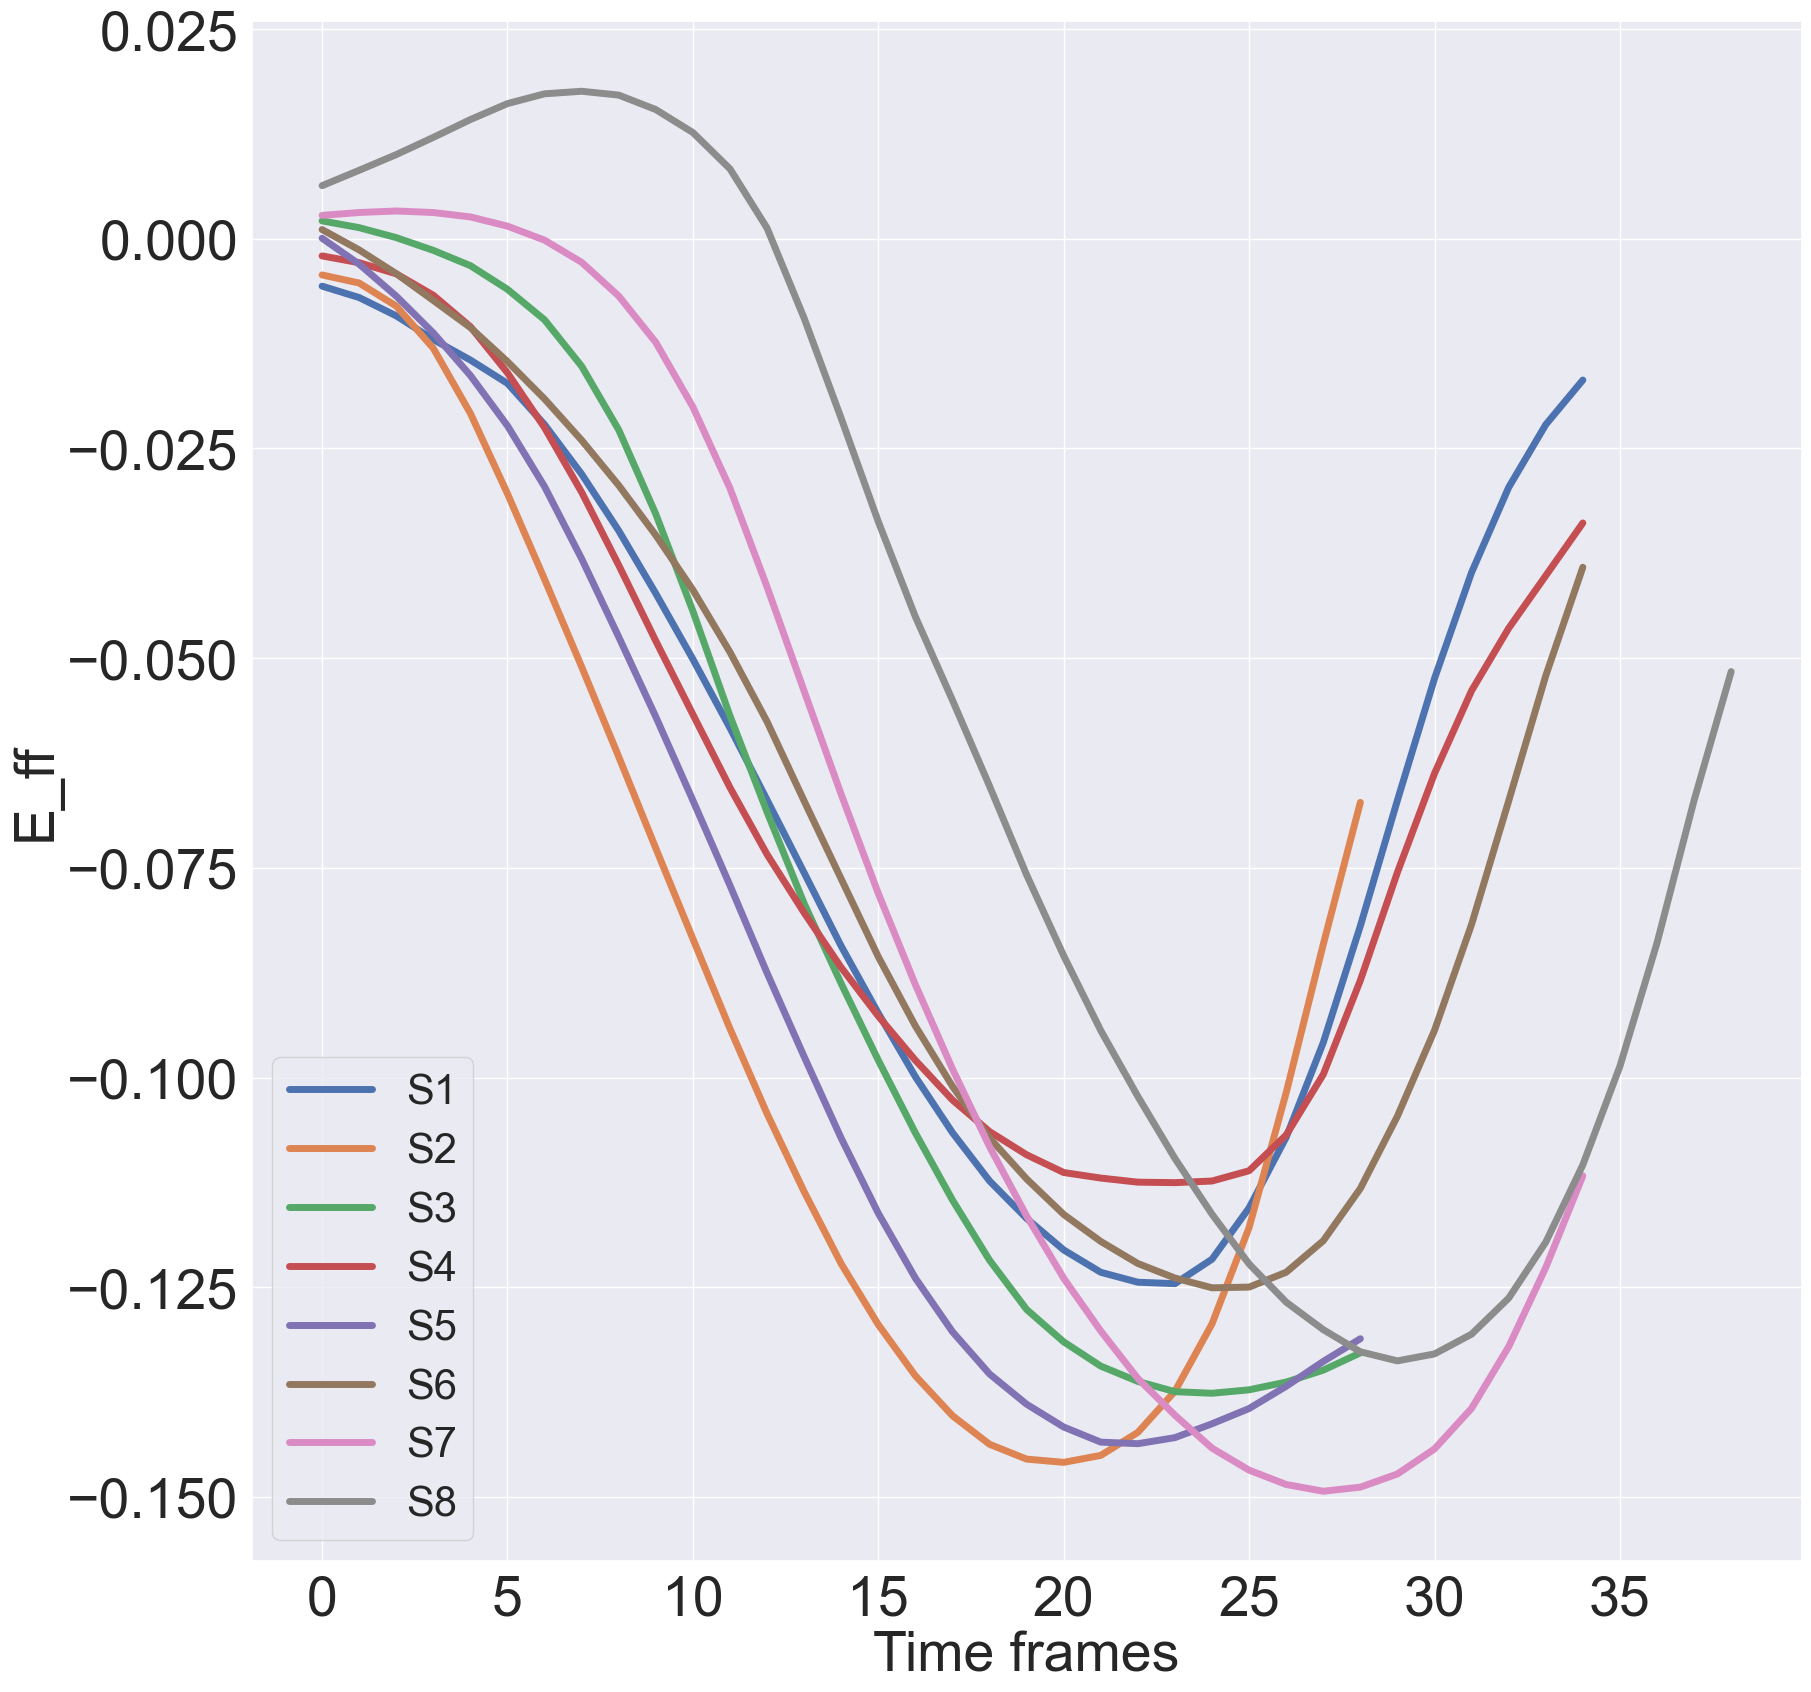

In [12]:
#50% points

fig = plt.figure(figsize=(20,20))

plt.plot(time_S1, S1_50, label = 'S1', linewidth = 5.0)
#plt.scatter(time_S1, S1_50, s = 150)
plt.plot(time_S2, S2_50, label = 'S2', linewidth = 5.0)
#plt.scatter(time_S2, S2_50, s = 150)
plt.plot(time_S3, S3_50, label = 'S3', linewidth = 5.0)
#plt.scatter(time_S3, S3_50, s = 150)
plt.plot(time_S4, S4_50, label = 'S4', linewidth = 5.0)
#plt.scatter(time_S4, S4_50, s = 150)
plt.plot(time_S5, S5_50, label = 'S5', linewidth = 5.0)
#plt.scatter(time_S5, S5_50, s = 150)
plt.plot(time_S6, S6_50, label = 'S6', linewidth = 5.0)
#plt.scatter(time_S6, S6_50, s = 150)
plt.plot(time_S7, S7_50, label = 'S7', linewidth = 5.0)
#plt.scatter(time_S7, S7_50, s = 150)
plt.plot(time_S8, S8_50, label = 'S8', linewidth = 5.0)
#plt.scatter(time_S8, S8_50, s = 150)
plt.ylabel("E_ff", fontsize = 40)
plt.xlabel("Time frames", fontsize = 40)
plt.xticks(fontsize=40)  # for x-axis
plt.yticks(fontsize=40)
plt.legend(fontsize = 30)
plt.savefig('Eff_plot/E_ff_50.png')

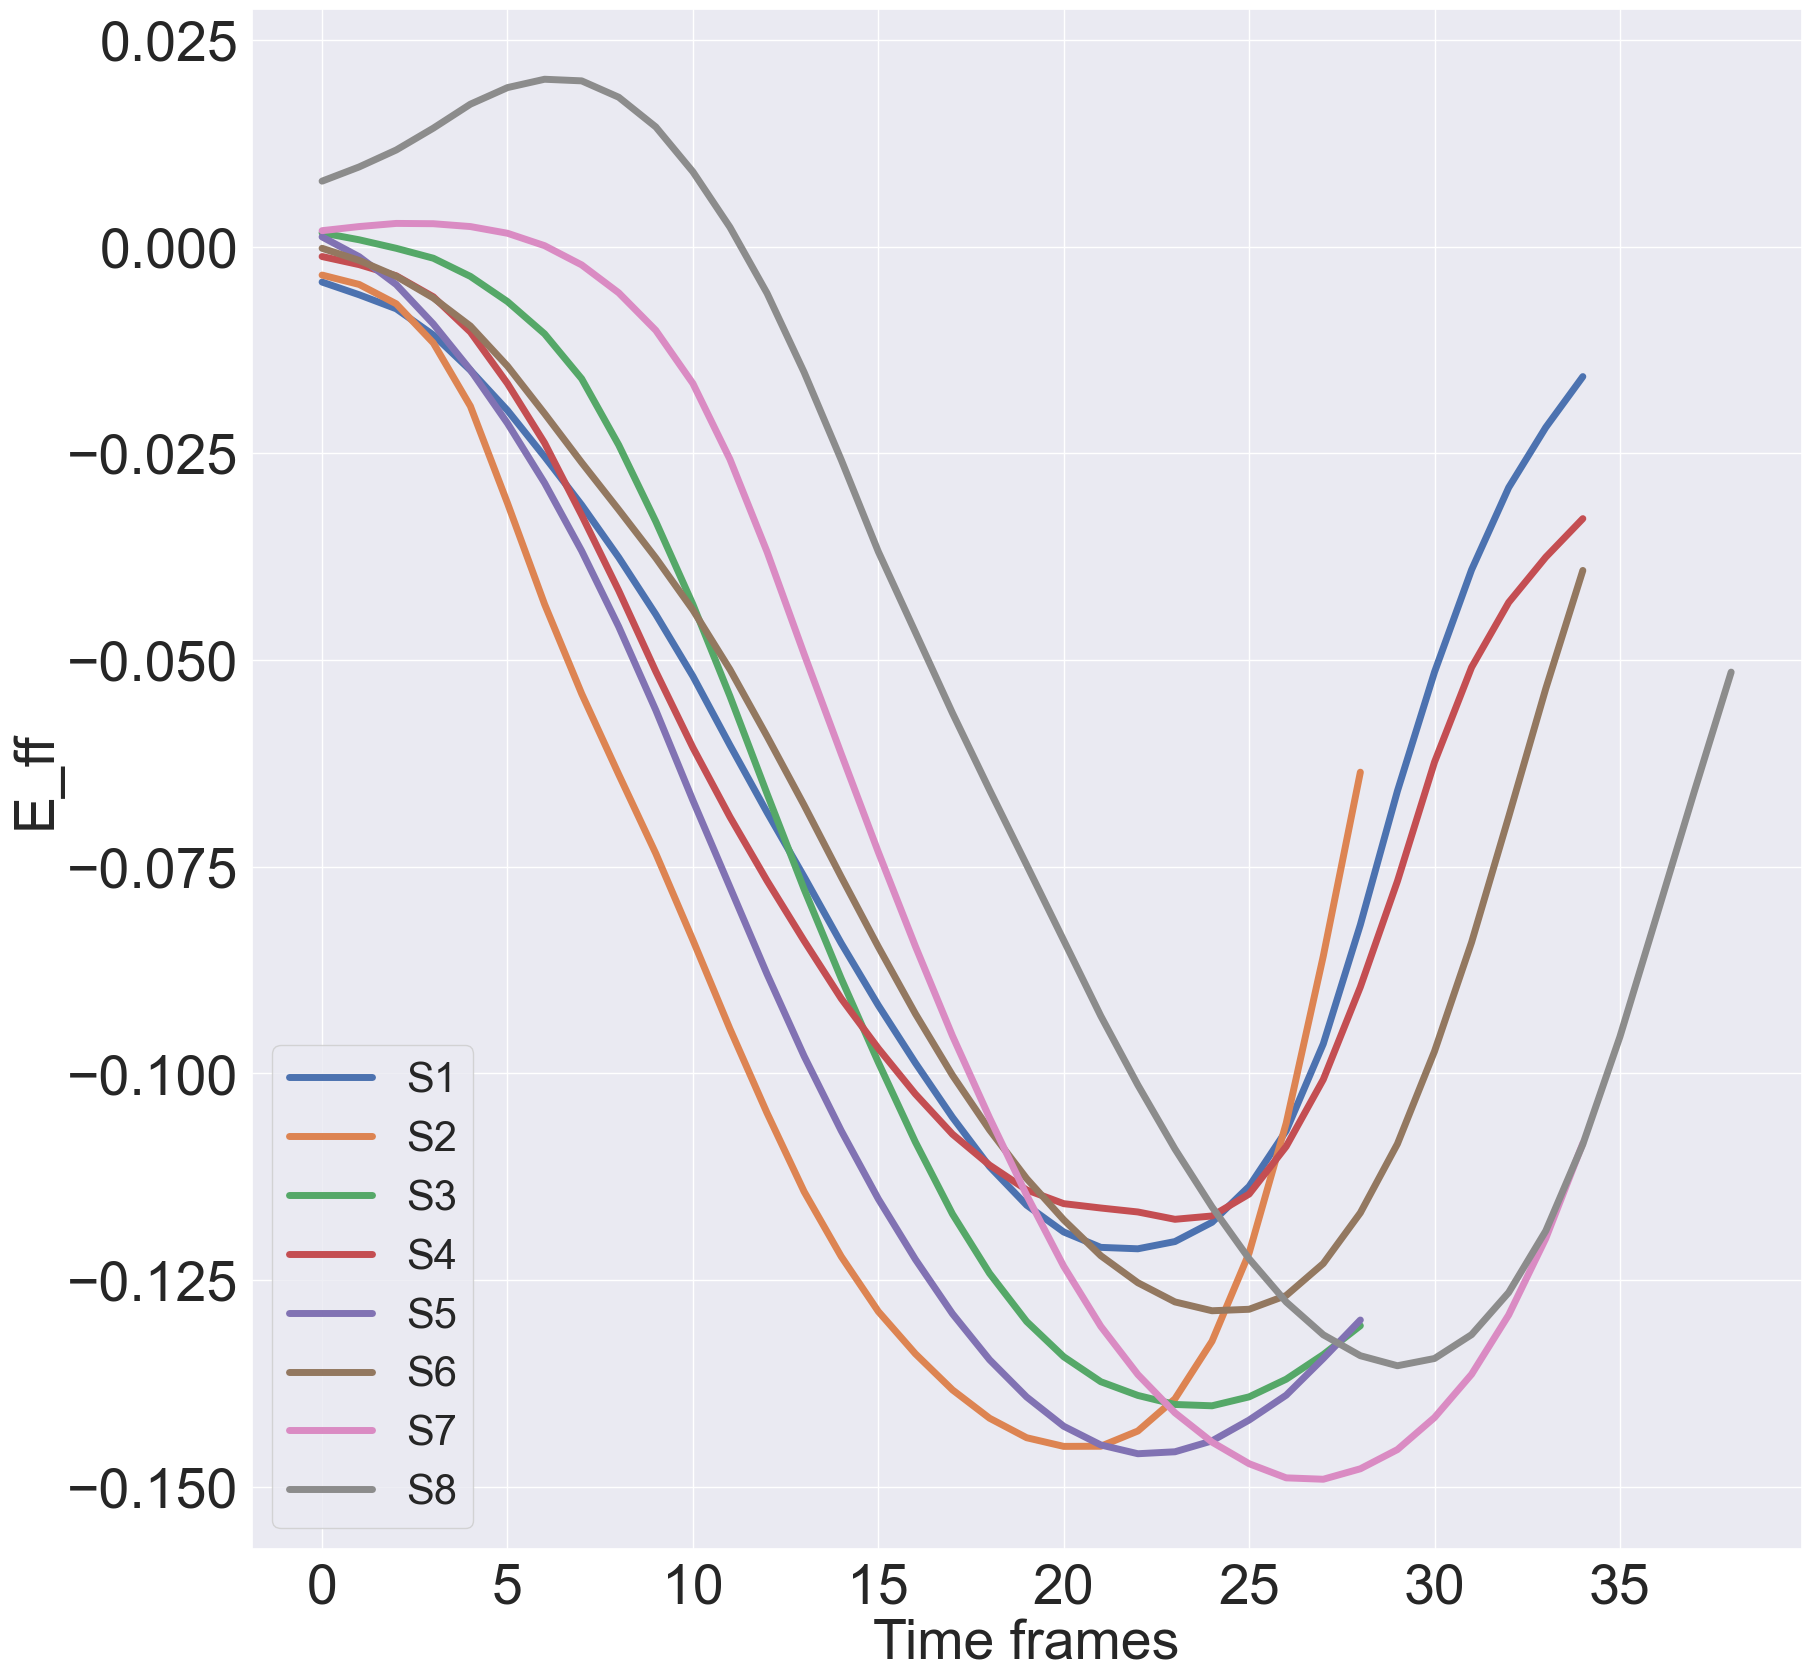

In [13]:
#80% points

fig = plt.figure(figsize=(20,20))

plt.plot(time_S1, S1_80, label = 'S1', linewidth = 5.0)
#plt.scatter(time_S1, S1_80, s = 150)
plt.plot(time_S2, S2_80, label = 'S2', linewidth = 5.0)
#plt.scatter(time_S2, S2_80, s = 150)
plt.plot(time_S3, S3_80, label = 'S3', linewidth = 5.0)
#plt.scatter(time_S3, S3_80, s = 150)
plt.plot(time_S4, S4_80, label = 'S4', linewidth = 5.0)
#plt.scatter(time_S4, S4_80, s = 150)
plt.plot(time_S5, S5_80, label = 'S5', linewidth = 5.0)
#plt.scatter(time_S5, S5_80, s = 150)
plt.plot(time_S6, S6_80, label = 'S6', linewidth = 5.0)
#plt.scatter(time_S6, S6_80, s = 150)
plt.plot(time_S7, S7_80, label = 'S7', linewidth = 5.0)
#plt.scatter(time_S7, S7_80, s = 150)
plt.plot(time_S8, S8_80, label = 'S8', linewidth = 5.0)
#plt.scatter(time_S8, S8_80, s = 150)
plt.ylabel("E_ff", fontsize = 40)
plt.xlabel("Time frames", fontsize = 40)
plt.xticks(fontsize=40)  # for x-axis
plt.yticks(fontsize=40)
plt.legend(fontsize = 30)
plt.savefig('Eff_plot/E_ff_80.png')

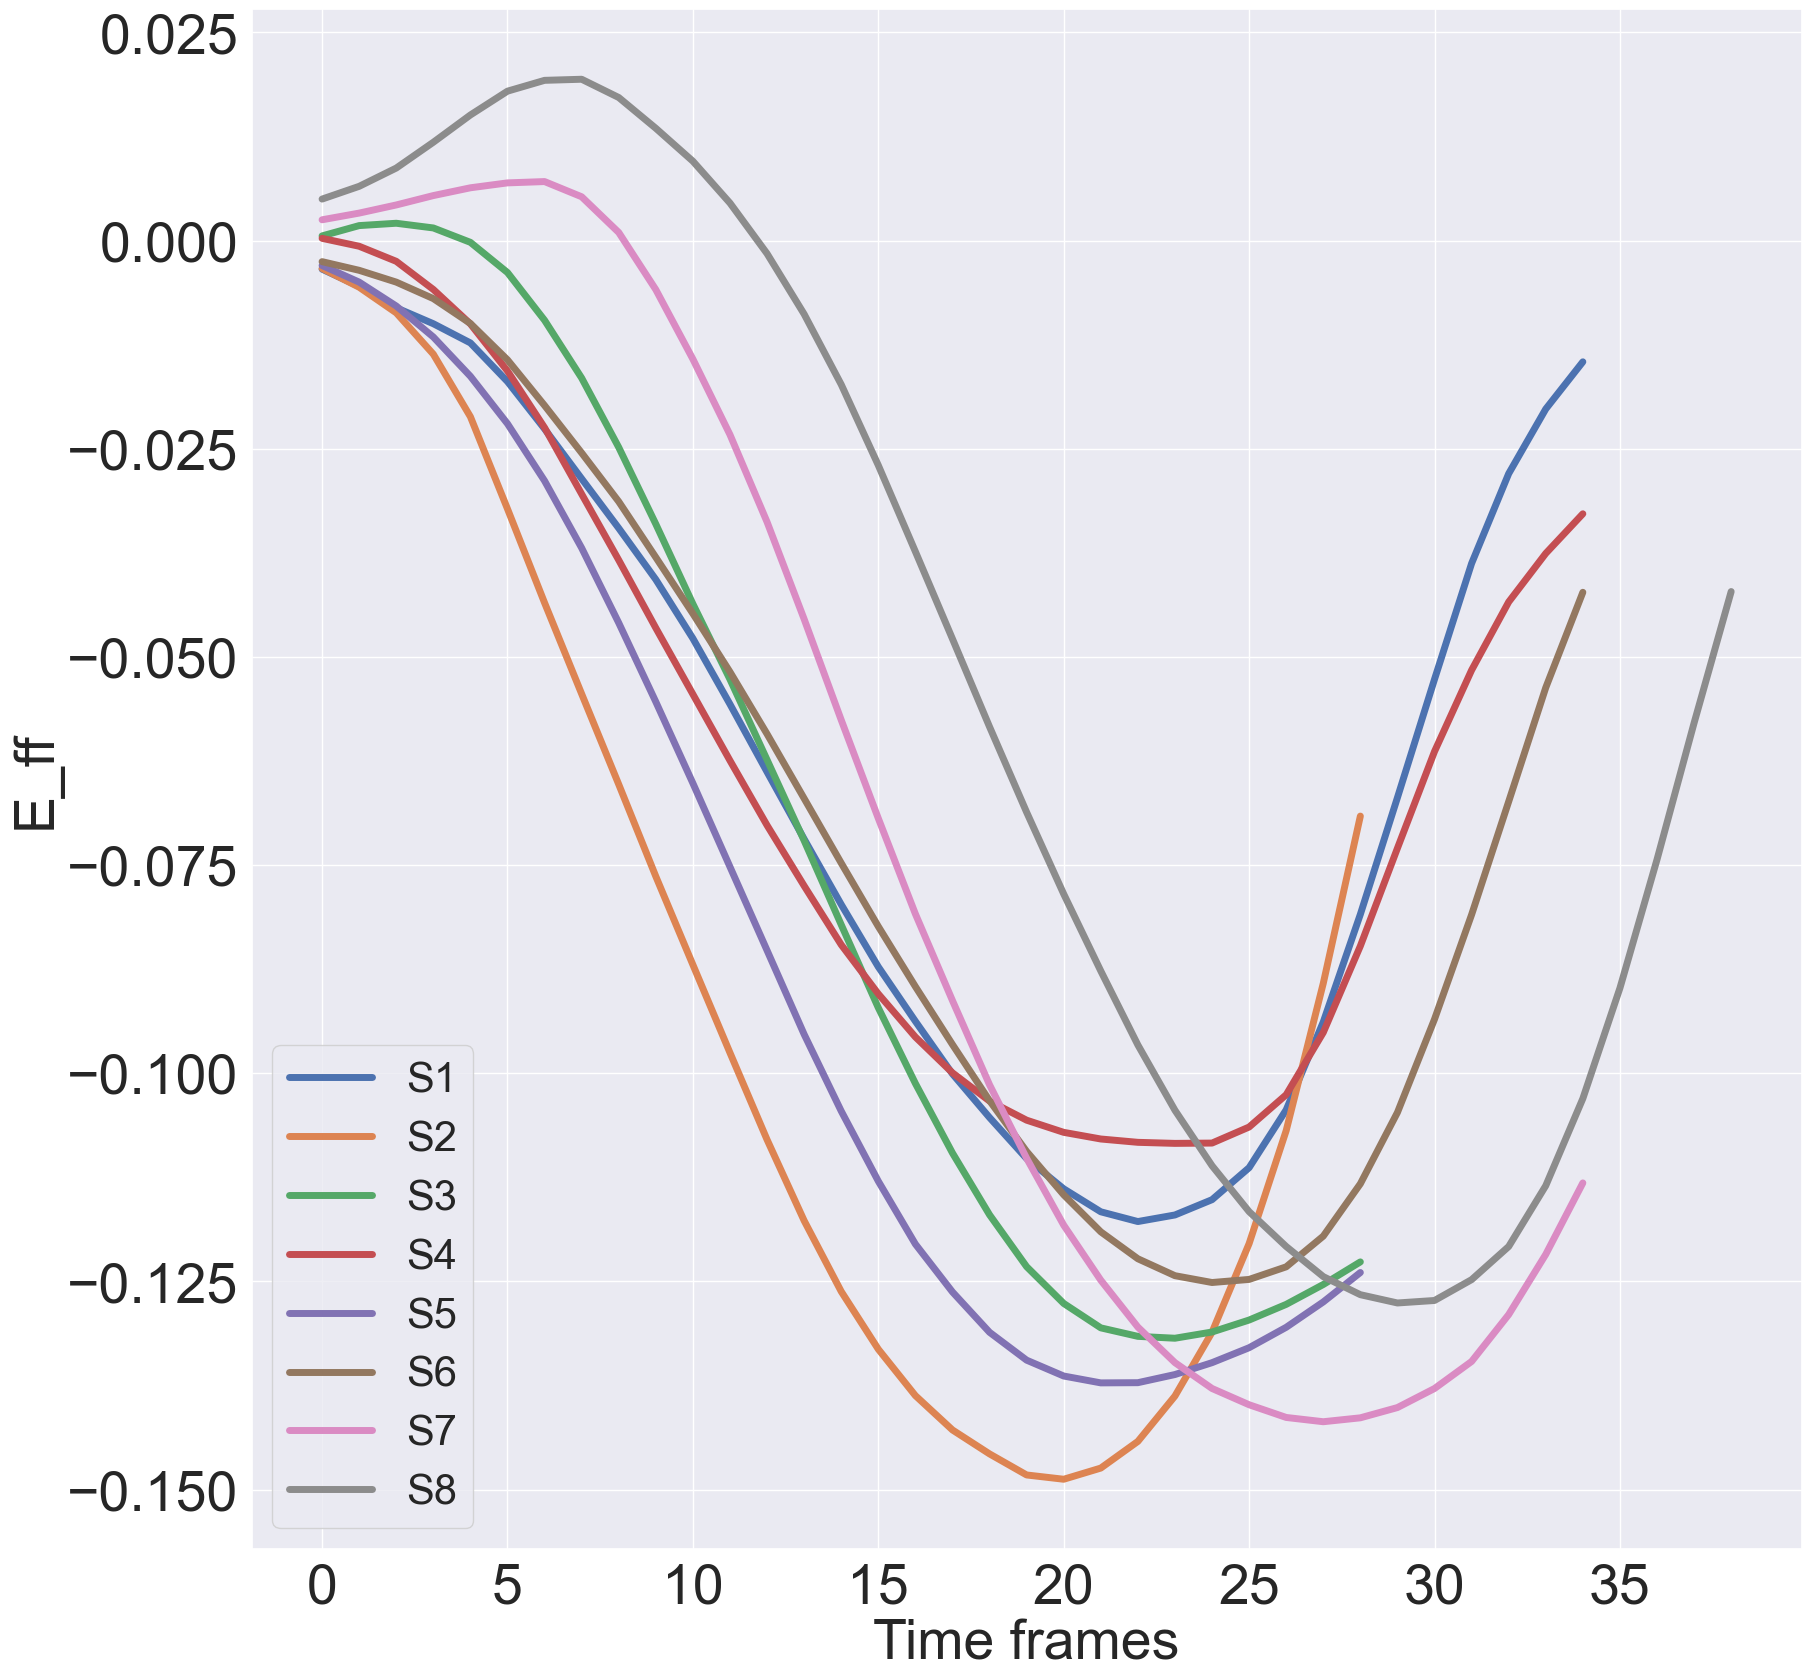

In [14]:
#no_mid points

fig = plt.figure(figsize=(20,20))

plt.plot(time_S1, S1_no_mid, label = 'S1', linewidth = 5.0)
#plt.scatter(time_S1, S1_no_mid, s = 150)
plt.plot(time_S2, S2_no_mid, label = 'S2', linewidth = 5.0)
#plt.scatter(time_S2, S2_no_mid, s = 150)
plt.plot(time_S3, S3_no_mid, label = 'S3', linewidth = 5.0)
#plt.scatter(time_S3, S3_no_mid, s = 150)
plt.plot(time_S4, S4_no_mid, label = 'S4', linewidth = 5.0)
#plt.scatter(time_S4, S4_no_mid, s = 150)
plt.plot(time_S5, S5_no_mid, label = 'S5', linewidth = 5.0)
#plt.scatter(time_S5, S5_no_mid, s = 150)
plt.plot(time_S6, S6_no_mid, label = 'S6', linewidth = 5.0)
#plt.scatter(time_S6, S6_no_mid, s = 150)
plt.plot(time_S7, S7_no_mid, label = 'S7', linewidth = 5.0)
#plt.scatter(time_S7, S7_no_mid, s = 150)
plt.plot(time_S8, S8_no_mid, label = 'S8', linewidth = 5.0)
#plt.scatter(time_S8, S8_no_mid, s = 150)
plt.ylabel("E_ff", fontsize = 40)
plt.xlabel("Time frames", fontsize = 40)
plt.xticks(fontsize=40)  # for x-axis
plt.yticks(fontsize=40)
plt.legend(fontsize = 30)
plt.savefig('Eff_plot/E_ff_no_mid.png')

In [7]:
S1_theta_50, S1_theta_80, S1_theta_nomid = [], [], []
S2_theta_50, S2_theta_80, S2_theta_nomid = [], [], []
S3_theta_50, S3_theta_80, S3_theta_nomid = [], [], []
S4_theta_50, S4_theta_80, S4_theta_nomid = [], [], []
S5_theta_50, S5_theta_80, S5_theta_nomid = [], [], []
S6_theta_50, S6_theta_80, S6_theta_nomid = [], [], []
S7_theta_50, S7_theta_80, S7_theta_nomid = [], [], []
S8_theta_50, S8_theta_80, S8_theta_nomid = [], [], []


for i in range(S1_50.shape[0]):
    S1_theta_50.append(np.genfromtxt('S1_data/S1_50/Theta_Loss/loss_theta_%i.csv' % i))
    S1_theta_80.append(np.genfromtxt('S1_data/S1_80/Theta_Loss/loss_theta_%i.csv' % i))
    S1_theta_nomid.append(np.genfromtxt('S1_data/S1_no_mid/Theta_Loss/loss_theta_%i.csv' % i))

S1_theta_50, S1_theta_80, S1_theta_nomid = jnp.array(S1_theta_50), jnp.array(S1_theta_80), jnp.array(S1_theta_nomid)

for i in range(S2_50.shape[0]):
    S2_theta_50.append(np.genfromtxt('S2_data/S2_50/Theta_Loss/loss_theta_%i.csv' % i))
    S2_theta_80.append(np.genfromtxt('S2_data/S2_80/Theta_Loss/loss_theta_%i.csv' % i))
    S2_theta_nomid.append(np.genfromtxt('S2_data/S2_no_mid/Theta_Loss/loss_theta_%i.csv' % i))

S2_theta_50, S2_theta_80, S2_theta_nomid = jnp.array(S2_theta_50), jnp.array(S2_theta_80), jnp.array(S2_theta_nomid)

for i in range(S3_50.shape[0]):
    S3_theta_50.append(np.genfromtxt('S3_data/S3_50/Theta_Loss/loss_theta_%i.csv' % i))
    S3_theta_80.append(np.genfromtxt('S3_data/S3_80/Theta_Loss/loss_theta_%i.csv' % i))
    S3_theta_nomid.append(np.genfromtxt('S3_data/S3_no_mid/Theta_Loss/loss_theta_%i.csv' % i))

S3_theta_50, S3_theta_80, S3_theta_nomid = jnp.array(S3_theta_50), jnp.array(S3_theta_80), jnp.array(S3_theta_nomid)

for i in range(S4_50.shape[0]):
    S4_theta_50.append(np.genfromtxt('S4_data/S4_50/Theta_Loss/loss_theta_%i.csv' % i))
    S4_theta_80.append(np.genfromtxt('S4_data/S4_80/Theta_Loss/loss_theta_%i.csv' % i))
    S4_theta_nomid.append(np.genfromtxt('S4_data/S4_no_mid/Theta_Loss/loss_theta_%i.csv' % i))

S4_theta_50, S4_theta_80, S4_theta_nomid = jnp.array(S4_theta_50), jnp.array(S4_theta_80), jnp.array(S4_theta_nomid)

for i in range(S5_50.shape[0]):
    S5_theta_50.append(np.genfromtxt('S5_data/S5_50/Theta_Loss/loss_theta_%i.csv' % i))
    S5_theta_80.append(np.genfromtxt('S5_data/S5_80/Theta_Loss/loss_theta_%i.csv' % i))
    S5_theta_nomid.append(np.genfromtxt('S5_data/S5_no_mid/Theta_Loss/loss_theta_%i.csv' % i))

S5_theta_50, S5_theta_80, S5_theta_nomid = jnp.array(S5_theta_50), jnp.array(S5_theta_80), jnp.array(S5_theta_nomid)

for i in range(S6_50.shape[0]):
    S6_theta_50.append(np.genfromtxt('S6_data/S6_50/Theta_Loss/loss_theta_%i.csv' % i))
    S6_theta_80.append(np.genfromtxt('S6_data/S6_80/Theta_Loss/loss_theta_%i.csv' % i))
    S6_theta_nomid.append(np.genfromtxt('S6_data/S6_no_mid/Theta_Loss/loss_theta_%i.csv' % i))

S6_theta_50, S6_theta_80, S6_theta_nomid = jnp.array(S6_theta_50), jnp.array(S6_theta_80), jnp.array(S6_theta_nomid)

for i in range(S7_50.shape[0]):
    S7_theta_50.append(np.genfromtxt('S7_data/S7_50/Theta_Loss/loss_theta_%i.csv' % i))
    S7_theta_80.append(np.genfromtxt('S7_data/S7_80/Theta_Loss/loss_theta_%i.csv' % i))
    S7_theta_nomid.append(np.genfromtxt('S7_data/S7_no_mid/Theta_Loss/loss_theta_%i.csv' % i))

S7_theta_50, S7_theta_80, S7_theta_nomid = jnp.array(S7_theta_50), jnp.array(S7_theta_80), jnp.array(S7_theta_nomid)

for i in range(S8_50.shape[0]):
    S8_theta_50.append(np.genfromtxt('S8_data/S8_50/Theta_Loss/loss_theta_%i.csv' % i))
    S8_theta_80.append(np.genfromtxt('S8_data/S8_80/Theta_Loss/loss_theta_%i.csv' % i))
    S8_theta_nomid.append(np.genfromtxt('S8_data/S8_no_mid/Theta_Loss/loss_theta_%i.csv' % i))

S8_theta_50, S8_theta_80, S8_theta_nomid = jnp.array(S8_theta_50), jnp.array(S8_theta_80), jnp.array(S8_theta_nomid)

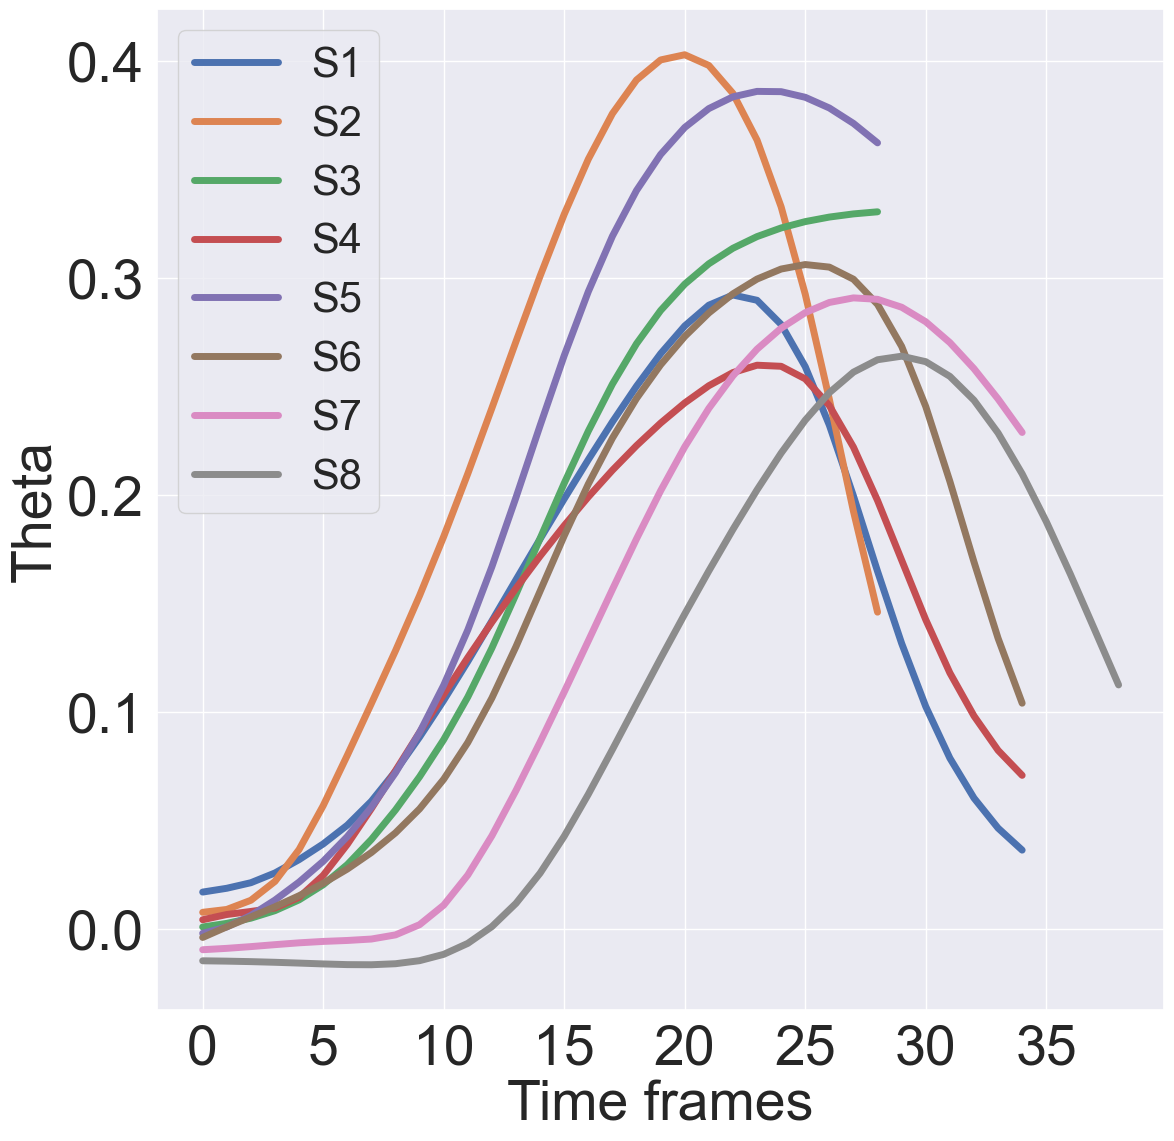

In [8]:
#50% points

fig = plt.figure(figsize=(13,13))

plt.plot(time_S1, S1_theta_50.mean(axis=1), label = 'S1', linewidth = 5.0)
plt.plot(time_S2, S2_theta_50.mean(axis=1), label = 'S2', linewidth = 5.0)
plt.plot(time_S3, S3_theta_50.mean(axis=1), label = 'S3', linewidth = 5.0)
plt.plot(time_S4, S4_theta_50.mean(axis=1), label = 'S4', linewidth = 5.0)
plt.plot(time_S5, S5_theta_50.mean(axis=1), label = 'S5', linewidth = 5.0)
plt.plot(time_S6, S6_theta_50.mean(axis=1), label = 'S6', linewidth = 5.0)
plt.plot(time_S7, S7_theta_50.mean(axis=1), label = 'S7', linewidth = 5.0)
plt.plot(time_S8, S8_theta_50.mean(axis=1), label = 'S8', linewidth = 5.0)
plt.ylabel("Theta", fontsize = 40)
plt.xlabel("Time frames", fontsize = 40)
plt.xticks(fontsize=40)  # for x-axis
plt.yticks(fontsize=40)
plt.legend(fontsize = 30)
plt.savefig('Eff_plot/Theta_50.png')

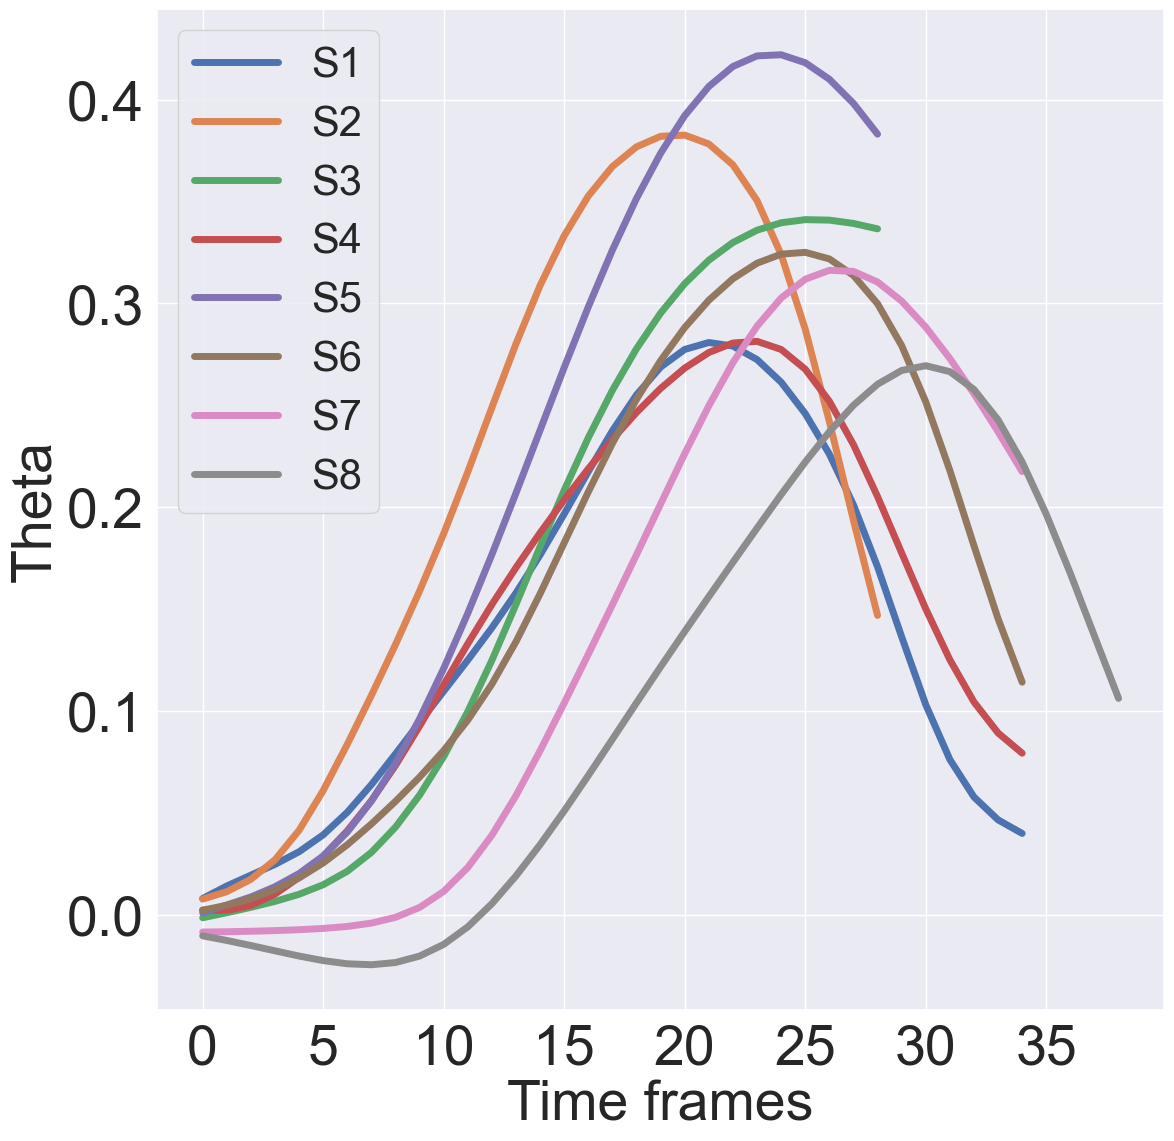

In [9]:
#80% points

fig = plt.figure(figsize=(13,13))

plt.plot(time_S1, S1_theta_80.mean(axis=1), label = 'S1', linewidth = 5.0)
plt.plot(time_S2, S2_theta_80.mean(axis=1), label = 'S2', linewidth = 5.0)
plt.plot(time_S3, S3_theta_80.mean(axis=1), label = 'S3', linewidth = 5.0)
plt.plot(time_S4, S4_theta_80.mean(axis=1), label = 'S4', linewidth = 5.0)
plt.plot(time_S5, S5_theta_80.mean(axis=1), label = 'S5', linewidth = 5.0)
plt.plot(time_S6, S6_theta_80.mean(axis=1), label = 'S6', linewidth = 5.0)
plt.plot(time_S7, S7_theta_80.mean(axis=1), label = 'S7', linewidth = 5.0)
plt.plot(time_S8, S8_theta_80.mean(axis=1), label = 'S8', linewidth = 5.0)
plt.ylabel("Theta", fontsize = 40)
plt.xlabel("Time frames", fontsize = 40)
plt.xticks(fontsize=40)  # for x-axis
plt.yticks(fontsize=40)
plt.legend(fontsize = 30)
plt.savefig('Eff_plot/Theta_80.png')

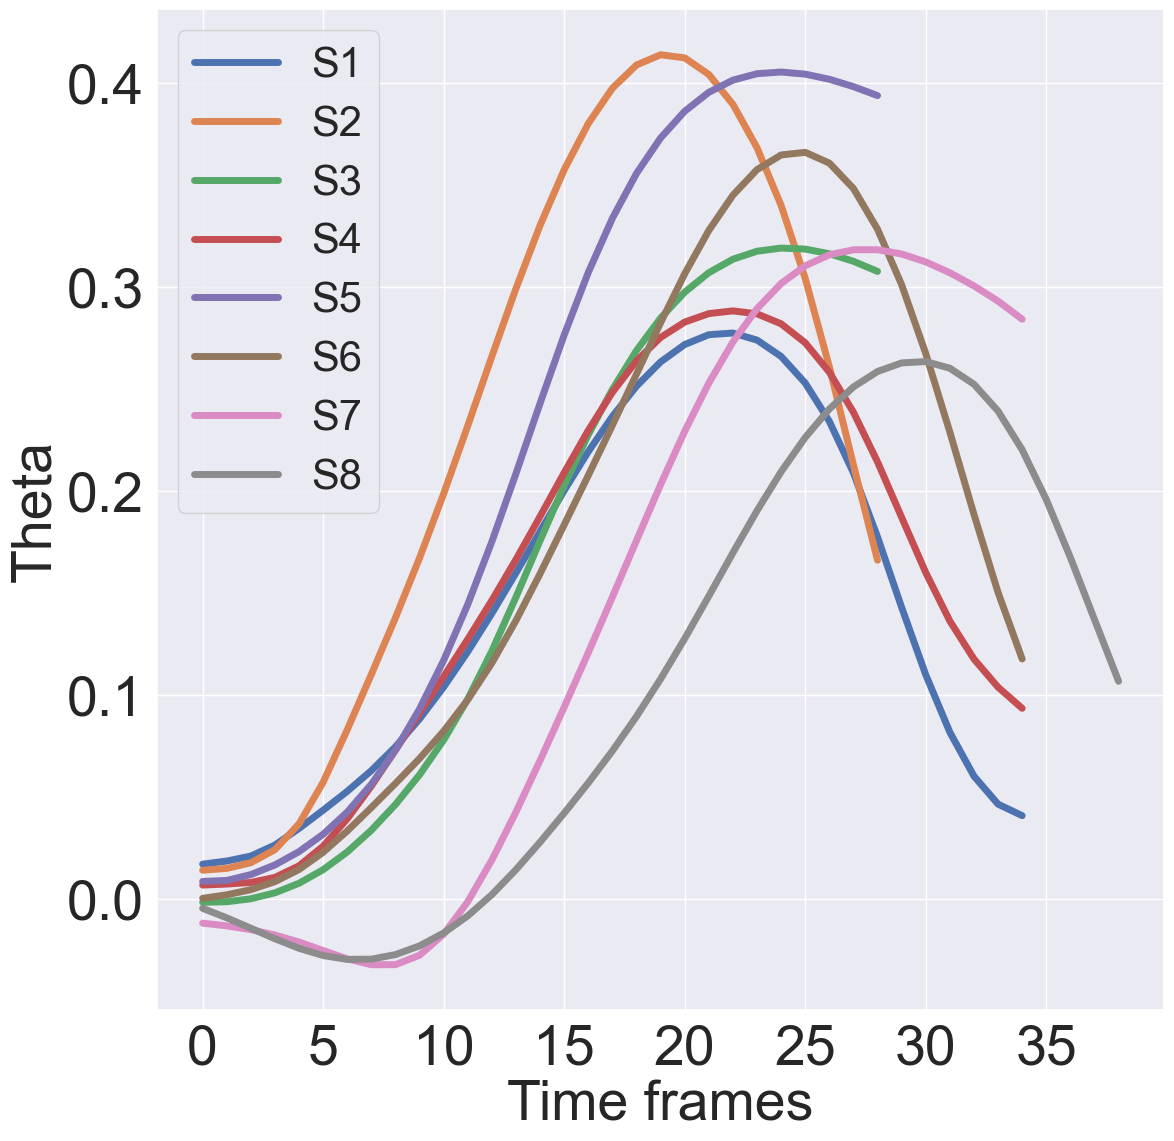

In [10]:
#no mid points

fig = plt.figure(figsize=(13,13))

plt.plot(time_S1, S1_theta_nomid.mean(axis=1), label = 'S1', linewidth = 5.0)
plt.plot(time_S2, S2_theta_nomid.mean(axis=1), label = 'S2', linewidth = 5.0)
plt.plot(time_S3, S3_theta_nomid.mean(axis=1), label = 'S3', linewidth = 5.0)
plt.plot(time_S4, S4_theta_nomid.mean(axis=1), label = 'S4', linewidth = 5.0)
plt.plot(time_S5, S5_theta_nomid.mean(axis=1), label = 'S5', linewidth = 5.0)
plt.plot(time_S6, S6_theta_nomid.mean(axis=1), label = 'S6', linewidth = 5.0)
plt.plot(time_S7, S7_theta_nomid.mean(axis=1), label = 'S7', linewidth = 5.0)
plt.plot(time_S8, S8_theta_nomid.mean(axis=1), label = 'S8', linewidth = 5.0)
plt.ylabel("Theta", fontsize = 40)
plt.xlabel("Time frames", fontsize = 40)
plt.xticks(fontsize=40)  # for x-axis
plt.yticks(fontsize=40)
plt.legend(fontsize = 30)
plt.savefig('Eff_plot/Theta_nomid.png')